# EN.601.687 - Machine Learning: Coping with Non-Stationary Environments and Errors FInal Project

## Project Title - Optimal Transport with Information Loss and Cluster Consistency for Improved Domain Adaptation
### Project Members - Rishi More (rmore2) and Chuan Lin (clin146)

### Installing necessary packages

In [ ]:
!pip install -q pot scikit-learn matplotlib numpy

### Importing necessary libraries and functions

In [ ]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm

import ot
import ot.plot
from ot.da import sinkhorn_lpl1_mm

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA

from scipy.ndimage import rotate, zoom
from scipy.special import softmax

# Set random seed for reproducibility
np.random.seed(42)

### Function to create a simple domain adaptation problem with 2D moon datasets

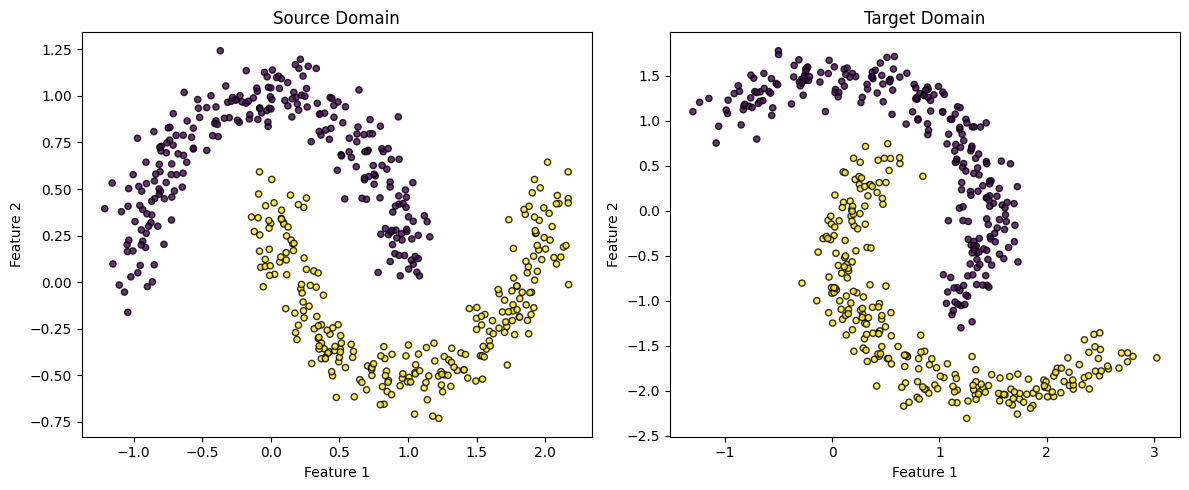

In [ ]:
def create_domain_adaptation_problem(n_samples=300, noise_level=0.1):
    # Source domain: standard moons dataset
    X_s, y_s = datasets.make_moons(n_samples=n_samples, noise=noise_level, random_state=42)

    # Target domain: rotated and scaled moons dataset (different distribution)
    X_t, y_t = datasets.make_moons(n_samples=n_samples, noise=noise_level, random_state=43)

    # Apply a transformation to create domain shift
    theta = np.pi / 4  # 45-degree rotation
    rotation_matrix = np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta), np.cos(theta)]
    ])
    X_t = np.dot(X_t, rotation_matrix)  # Apply rotation
    X_t = X_t * 1.5  # Apply scaling

    return X_s, y_s, X_t, y_t

# Create the source and target domains
X_source, y_source, X_target, y_target = create_domain_adaptation_problem(n_samples=500, noise_level=0.1)

# Split source data into train and test
X_source_train, X_source_test, y_source_train, y_source_test = train_test_split(
    X_source, y_source, test_size=0.2, random_state=42
)

# Visualize the domains
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(X_source[:, 0], X_source[:, 1], c=y_source, cmap='viridis', alpha=0.8, s=20, edgecolors='k')
plt.title('Source Domain')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

plt.subplot(1, 2, 2)
plt.scatter(X_target[:, 0], X_target[:, 1], c=y_target, cmap='viridis', alpha=0.8, s=20, edgecolors='k')
plt.title('Target Domain')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

plt.tight_layout()
plt.show()

### Standardize features

In [ ]:
scaler = StandardScaler()
X_source_scaled = scaler.fit_transform(X_source)
X_target_scaled = scaler.transform(X_target)

# Function to evaluate classifier without adaptation
def evaluate_without_adaptation(X_s_train, y_s_train, X_t_test, y_t_test):
    # Train a classifier on source domain
    clf = KNeighborsClassifier(n_neighbors=5)
    clf.fit(X_s_train, y_s_train)

    # Test on target domain
    y_pred = clf.predict(X_t_test)
    accuracy = accuracy_score(y_t_test, y_pred)

    return accuracy, clf

### Function to perform domain adaptation using optimal transport

In [ ]:
def ot_domain_adaptation(X_s, y_s, X_t, y_t, reg_e=1e-1, reg_cl=0.1):
    """
    Domain adaptation using optimal transport with class regularization

    Parameters:
    - X_s: Source domain features
    - y_s: Source domain labels
    - X_t: Target domain features
    - y_t: Target domain labels (only used for evaluation)
    - reg_e: Entropy regularization parameter for Sinkhorn (was hardcoded, now parameterized)
    - reg_cl: Class regularization parameter (not used directly in this basic implementation)

    Returns:
    - X_t_adapted: Adapted target features
    - transport_matrix: The optimal transport plan
    """

    n_source = X_s.shape[0]
    n_target = X_t.shape[0]

    # Cost matrix (squared Euclidean distance), normalized
    M = ot.dist(X_s, X_t, metric='sqeuclidean')
    M = M / (M.max() + 1e-9)  # Normalize + prevent divide-by-zero

    # Uniform distributions
    a = np.ones((n_source,)) / n_source
    b = np.ones((n_target,)) / n_target

    # Class-based regularization matrix (placeholder; not directly used)
    classes = np.unique(y_s)
    T0 = np.zeros((n_source, n_target))
    for c in classes:
        idx_s = np.where(y_s == c)[0]
        idx_t = np.arange(n_target)
        for i in idx_s:
            T0[i, idx_t] = 1.0 / (len(idx_s) * len(idx_t))
    T0 = T0 / T0.sum()

    # Sinkhorn transport (with increased regularization to stabilize)
    try:
        transport_matrix = ot.sinkhorn(a, b, M, reg=reg_e)
    except Exception as e:
        raise RuntimeError(f"Sinkhorn transport failed: {e}")

    # Normalize transport matrix safely (avoid divide-by-zero)
    col_sums = transport_matrix.sum(axis=0, keepdims=True)
    col_sums[col_sums == 0] = 1e-8  # prevent division by zero

    X_t_adapted = (transport_matrix / col_sums).T @ X_s

    # Optionally: handle any remaining NaNs
    if np.isnan(X_t_adapted).any():
        print("⚠️ NaNs detected in adapted data, applying fallback replacement.")
        X_t_adapted = np.nan_to_num(X_t_adapted)

    return X_t_adapted, transport_matrix


# Perform domain adaptation
X_target_adapted, transport_matrix = ot_domain_adaptation(
    X_source_scaled, y_source, X_target_scaled, y_target, reg_e=0.01, reg_cl=0.1
)

# Evaluate classifier before and after adaptation
accuracy_before, clf_before = evaluate_without_adaptation(
    X_source_scaled, y_source, X_target_scaled, y_target
)

accuracy_after, clf_after = evaluate_without_adaptation(
    X_source_scaled, y_source, X_target_adapted, y_target
)

print(f"Accuracy before adaptation: {accuracy_before:.4f}")
print(f"Accuracy after adaptation: {accuracy_after:.4f}")

Accuracy before adaptation: 0.8280
Accuracy after adaptation: 0.8720


<ipython-input-21-0119636c8283>:50: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


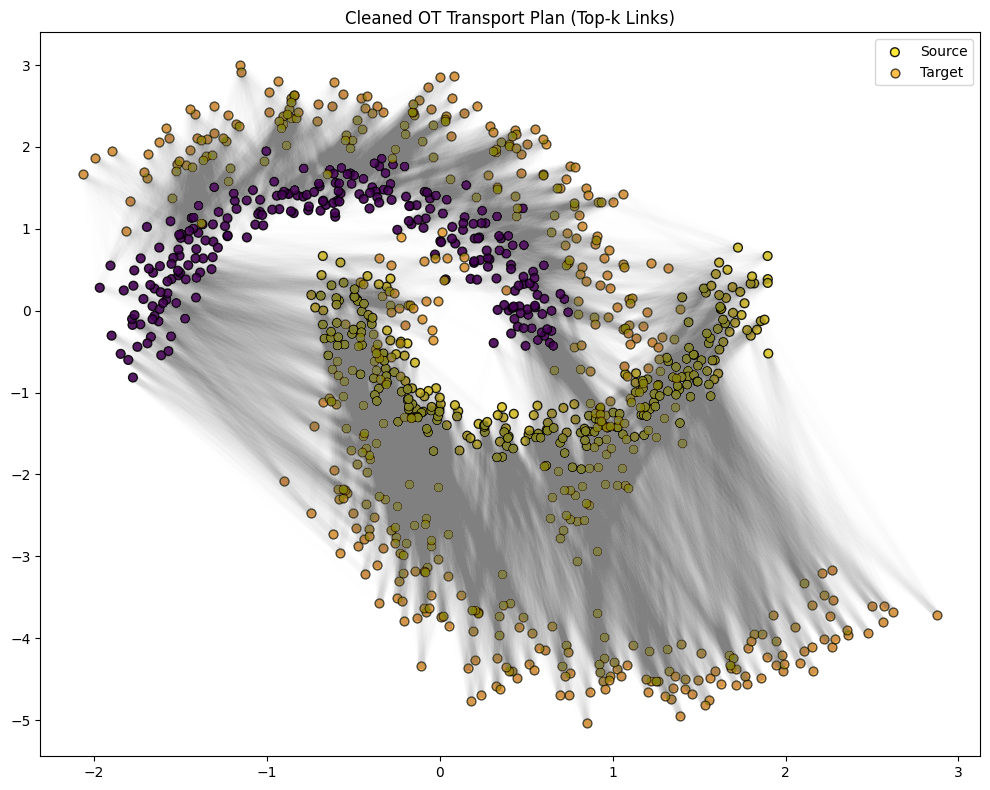

In [ ]:
def plot_ot_transport_clean(
    X_s, X_t, T, y_s=None, y_t=None, top_k=3
):
    plt.figure(figsize=(10, 8))

    # Normalize y_s for colormap
    if y_s is not None:
        y_s_norm = y_s / y_s.max()
        source_colors = cm.viridis(y_s_norm)
    else:
        source_colors = 'blue'

    # Plot top-k transport links only
    for i in range(T.shape[0]):
        top_indices = np.argsort(T[i])[-top_k:]  # top k target indices for source i
        for j in top_indices:
            alpha = min(T[i, j] * 100, 1.0)  # scale transparency
            plt.plot(
                [X_s[i, 0], X_t[j, 0]],
                [X_s[i, 1], X_t[j, 1]],
                color='gray',
                alpha=alpha,
                linewidth=5
            )

    # Plot source points
    plt.scatter(
        X_s[:, 0],
        X_s[:, 1],
        c=source_colors,
        label='Source',
        s=40,
        edgecolor='k',
        alpha=0.9
    )

    # Plot target points
    plt.scatter(
        X_t[:, 0],
        X_t[:, 1],
        c='orange',
        label='Target',
        s=40,
        edgecolor='k',
        alpha=0.7
    )

    plt.title("Cleaned OT Transport Plan (Top-k Links)")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_ot_transport_clean(X_source_scaled, X_target_scaled, transport_matrix, y_s=y_source, top_k=100)

### Visualize the data before and after adaptation using t-SNE for better visualization

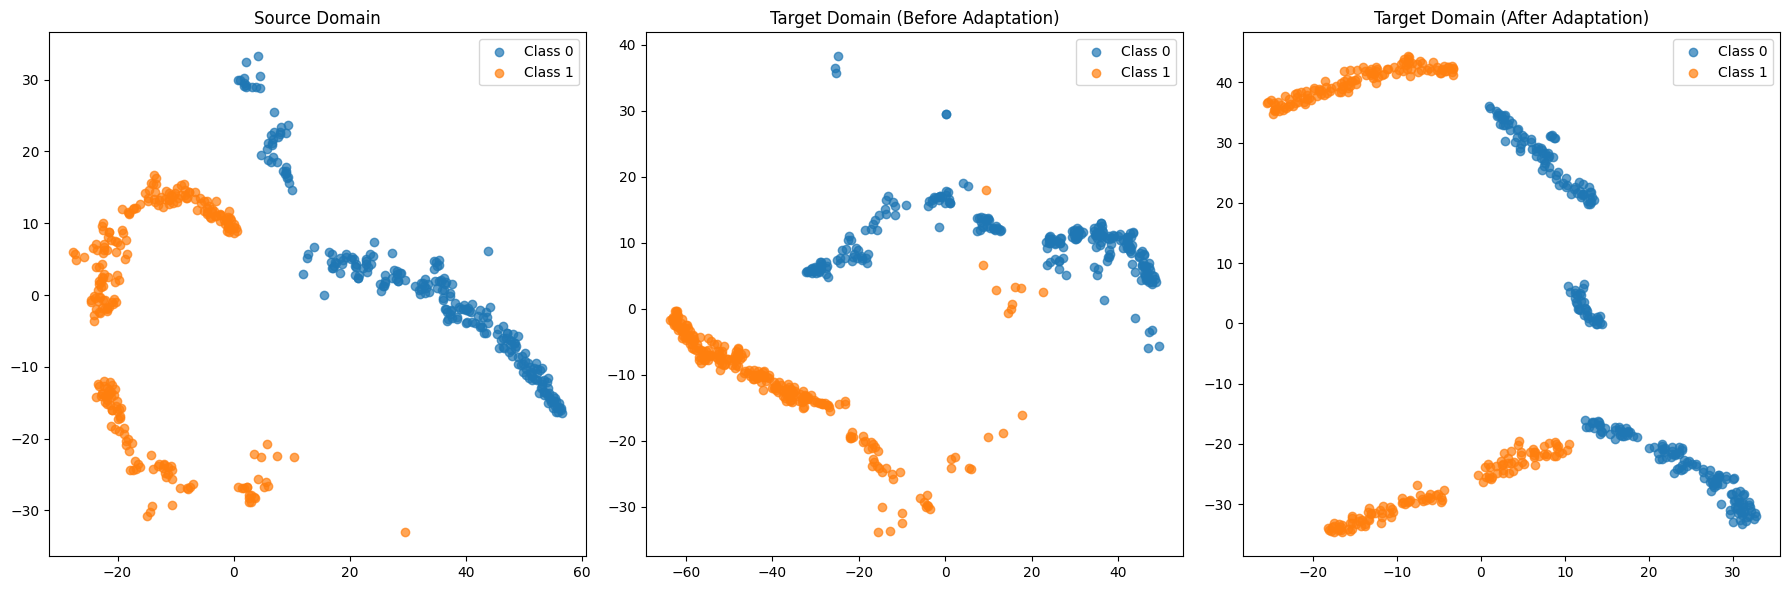

In [ ]:
def plot_tsne_comparison(X_s, y_s, X_t_before, X_t_after, y_t):
    # Apply t-SNE to visualize high-dimensional data in 2D
    tsne = TSNE(n_components=2, random_state=42)

    # Combine data for consistent t-SNE embedding
    X_combined = np.vstack([X_s, X_t_before, X_t_after])
    tsne_combined = tsne.fit_transform(X_combined)

    # Split back into source, target before, and target after
    n_source = X_s.shape[0]
    n_target = X_t_before.shape[0]

    tsne_source = tsne_combined[:n_source]
    tsne_target_before = tsne_combined[n_source:n_source+n_target]
    tsne_target_after = tsne_combined[n_source+n_target:]

    # Plot
    plt.figure(figsize=(18, 6))

    # Source domain
    plt.subplot(1, 3, 1)
    for c in np.unique(y_s):
        idx = y_s == c
        plt.scatter(tsne_source[idx, 0], tsne_source[idx, 1], label=f'Class {c}', alpha=0.7)
    plt.title('Source Domain')
    plt.legend()

    # Target domain before adaptation
    plt.subplot(1, 3, 2)
    for c in np.unique(y_t):
        idx = y_t == c
        plt.scatter(tsne_target_before[idx, 0], tsne_target_before[idx, 1], label=f'Class {c}', alpha=0.7)
    plt.title('Target Domain (Before Adaptation)')
    plt.legend()

    # Target domain after adaptation
    plt.subplot(1, 3, 3)
    for c in np.unique(y_t):
        idx = y_t == c
        plt.scatter(tsne_target_after[idx, 0], tsne_target_after[idx, 1], label=f'Class {c}', alpha=0.7)
    plt.title('Target Domain (After Adaptation)')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Visualize the comparison
plot_tsne_comparison(X_source_scaled, y_source, X_target_scaled, X_target_adapted, y_target)


### Example with a real-world dataset: MNIST to USPS digits




MNIST-USPS adaptation accuracy before: 0.7160
MNIST-USPS adaptation accuracy after: 0.7740


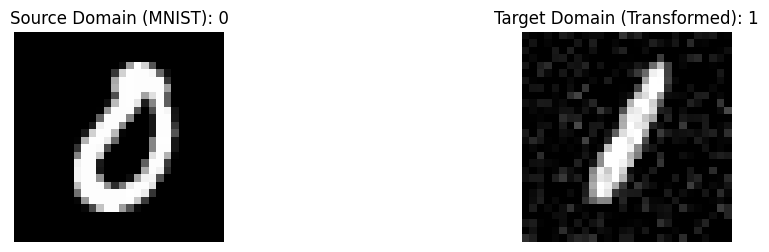

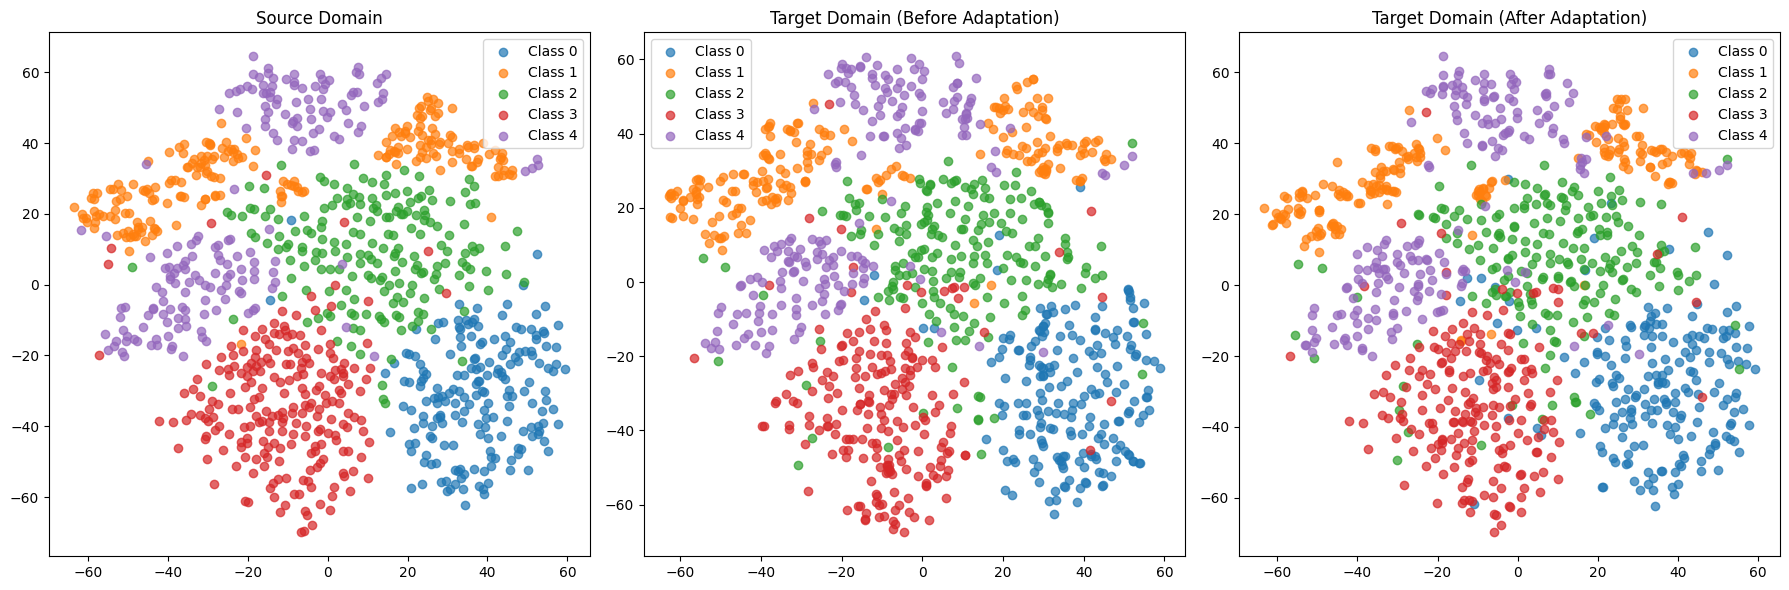

In [ ]:
def mnist_usps_adaptation():
    # First, let's create a simplified version of MNIST vs USPS adaptation
    # For this example, we'll use MNIST dataset but create a synthetic domain shift

    mnist = fetch_openml('mnist_784', version=1, as_frame=False, parser='auto')
    X, y = mnist.data, mnist.target.astype(int)


    idx = np.where((y >= 0) & (y < 5))[0]
    X, y = X[idx], y[idx]
    idx = np.random.choice(len(X), 2000, replace=False)
    X, y = X[idx], y[idx]

    X = X / 255.0
    X_source, X_target, y_source, y_target = train_test_split(X, y, test_size=0.5, random_state=42)

    def transform_images(X, image_size=28):
        X_transformed = np.zeros_like(X)
        for i in range(len(X)):
            img = X[i].reshape(image_size, image_size)

            # Apply a slight rotation and scaling (to simulate different writing styles)
            angle = np.random.uniform(-10, 10)
            img = rotate(img, angle, reshape=False)

            scale = np.random.uniform(0.8, 1.2)
            img = zoom(img, scale, order=1)

            # Crop or pad to maintain original size
            h, w = img.shape
            if h > image_size or w > image_size:
                # Crop the center
                start_h = max(0, (h - image_size) // 2)
                start_w = max(0, (w - image_size) // 2)
                img = img[start_h:start_h+image_size, start_w:start_w+image_size]
            else:
                # Pad with zeros
                new_img = np.zeros((image_size, image_size))
                start_h = max(0, (image_size - h) // 2)
                start_w = max(0, (image_size - w) // 2)
                new_img[start_h:start_h+h, start_w:start_w+w] = img
                img = new_img

            # Add noise
            img = img + np.random.normal(0, 0.1, img.shape)
            img = np.clip(img, 0, 1)

            X_transformed[i] = img.flatten()

        return X_transformed

    X_target = transform_images(X_target)

    # Reduce dimensionality for faster computation
    pca = PCA(n_components=50)
    X_source_pca = pca.fit_transform(X_source)
    X_target_pca = pca.transform(X_target)

    # Standardize
    scaler = StandardScaler()
    X_source_scaled = scaler.fit_transform(X_source_pca)
    X_target_scaled = scaler.transform(X_target_pca)

    # Evaluate before adaptation
    accuracy_before, _ = evaluate_without_adaptation(X_source_scaled, y_source, X_target_scaled, y_target)

    # Perform adaptation
    X_target_adapted, _ = ot_domain_adaptation(X_source_scaled, y_source, X_target_scaled, y_target,
                                              reg_e=0.01, reg_cl=0.1)

    # Evaluate after adaptation
    accuracy_after, _ = evaluate_without_adaptation(X_source_scaled, y_source, X_target_adapted, y_target)

    print(f"MNIST-USPS adaptation accuracy before: {accuracy_before:.4f}")
    print(f"MNIST-USPS adaptation accuracy after: {accuracy_after:.4f}")

    # Visualize some samples
    plt.figure(figsize=(12, 6))

    plt.subplot(2, 2, 1)
    idx = np.random.choice(len(X_source), 1)[0]
    plt.imshow(X_source[idx].reshape(28, 28), cmap='gray')
    plt.title(f'Source Domain (MNIST): {y_source[idx]}')
    plt.axis('off')

    plt.subplot(2, 2, 2)
    idx = np.random.choice(len(X_target), 1)[0]
    plt.imshow(X_target[idx].reshape(28, 28), cmap='gray')
    plt.title(f'Target Domain (Transformed): {y_target[idx]}')
    plt.axis('off')

    # Show t-SNE visualization
    plot_tsne_comparison(X_source_scaled, y_source, X_target_scaled, X_target_adapted, y_target)

# Run MNIST-USPS adaptation experiment
mnist_usps_adaptation()

### Semi-supervised version of Optimal Transport

In [ ]:
def ot_semisupervised_domain_adaptation(X_s, y_s, X_t, y_t_partial, reg_e=0.01, reg_cl=0.1):
    # Semi-supervised domain adaptation using partially labeled target
    transp = ot.da.SinkhornLpl1Transport(reg_e=reg_e, reg_cl=reg_cl)
    transp.fit(Xs=X_s, ys=y_s, Xt=X_t, yt=y_t_partial)
    X_t_transported = transp.transform(X_t)
    return X_t_transported, transp

### Testing semi-supervised adaptation


Testing Semi-Supervised Domain Adaptation
No adaptation accuracy: 0.8133
Unsupervised OT-DA accuracy: 0.8333
Semi-supervised OT-DA accuracy (10% labeled): 0.7800


/usr/local/lib/python3.11/dist-packages/ot/bregman/_sinkhorn.py:631: RuntimeWarning: divide by zero encountered in divide
  v = b / KtransposeU
/usr/local/lib/python3.11/dist-packages/ot/bregman/_sinkhorn.py:631: RuntimeWarning: overflow encountered in divide
  v = b / KtransposeU
/usr/local/lib/python3.11/dist-packages/ot/bregman/_sinkhorn.py:643: UserWarning: Warning: numerical errors at iteration 0
  warnings.warn("Warning: numerical errors at iteration %d" % ii)


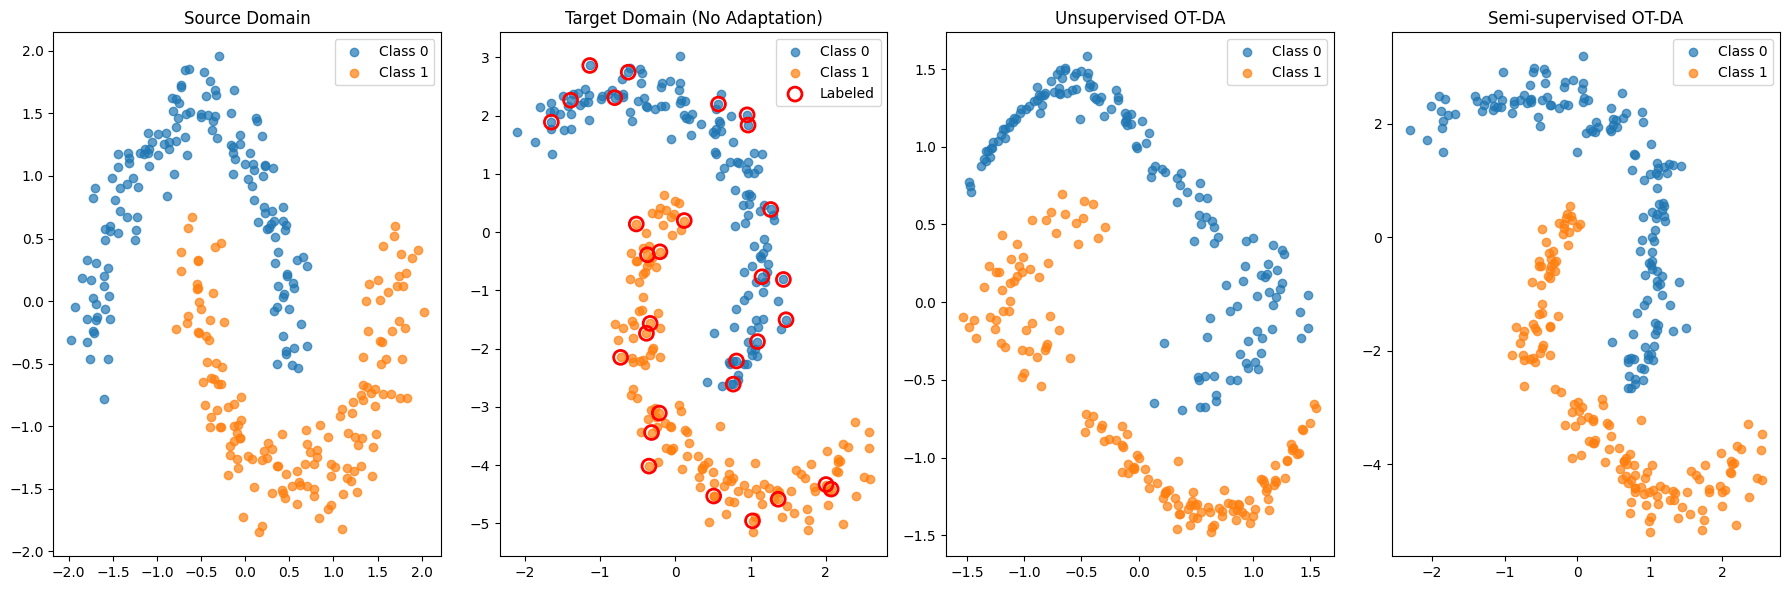

In [ ]:
def test_semisupervised():
    print("\nTesting Semi-Supervised Domain Adaptation")

    # Create domain adaptation problem
    X_s, y_s, X_t, y_t = create_domain_adaptation_problem(n_samples=300)

    # Standardize
    scaler = StandardScaler()
    X_s = scaler.fit_transform(X_s)
    X_t = scaler.transform(X_t)

    # Create partial labels scenario (only 10% of target samples are labeled)
    n_labeled = int(0.1 * len(y_t))
    labeled_idx = np.random.choice(len(y_t), n_labeled, replace=False)
    y_t_partial = np.full_like(y_t, -1)  # -1 for unlabeled
    y_t_partial[labeled_idx] = y_t[labeled_idx]

    # Unsupervised OT-DA
    X_t_unsup, _ = ot_domain_adaptation(X_s, y_s, X_t, y_t, reg_e=0.01, reg_cl=0.01)
    unsup_acc, _ = evaluate_without_adaptation(X_s, y_s, X_t_unsup, y_t)

    # Semi-supervised OT-DA
    X_t_semisup, _ = ot_semisupervised_domain_adaptation(X_s, y_s, X_t, y_t_partial, reg_e=0.01, reg_cl=0.01)
    semisup_acc, _ = evaluate_without_adaptation(X_s, y_s, X_t_semisup, y_t)

    # No adaptation
    no_adapt_acc, _ = evaluate_without_adaptation(X_s, y_s, X_t, y_t)

    print(f"No adaptation accuracy: {no_adapt_acc:.4f}")
    print(f"Unsupervised OT-DA accuracy: {unsup_acc:.4f}")
    print(f"Semi-supervised OT-DA accuracy (10% labeled): {semisup_acc:.4f}")

    # Visualize
    plt.figure(figsize=(18, 6))

    # Source
    plt.subplot(1, 4, 1)
    for c in np.unique(y_s):
        idx = y_s == c
        plt.scatter(X_s[idx, 0], X_s[idx, 1], label=f'Class {c}', alpha=0.7)
    plt.title('Source Domain')
    plt.legend()

    # Target (no adaptation)
    plt.subplot(1, 4, 2)
    for c in np.unique(y_t):
        idx = y_t == c
        plt.scatter(X_t[idx, 0], X_t[idx, 1], label=f'Class {c}', alpha=0.7)
    plt.scatter(X_t[labeled_idx, 0], X_t[labeled_idx, 1], s=100, facecolors='none',
                edgecolors='red', linewidth=2, label='Labeled')
    plt.title('Target Domain (No Adaptation)')
    plt.legend()

    # Target after unsupervised adaptation
    plt.subplot(1, 4, 3)
    for c in np.unique(y_t):
        idx = y_t == c
        plt.scatter(X_t_unsup[idx, 0], X_t_unsup[idx, 1], label=f'Class {c}', alpha=0.7)
    plt.title('Unsupervised OT-DA')
    plt.legend()

    # Target after semi-supervised adaptation
    plt.subplot(1, 4, 4)
    for c in np.unique(y_t):
        idx = y_t == c
        plt.scatter(X_t_semisup[idx, 0], X_t_semisup[idx, 1], label=f'Class {c}', alpha=0.7)
    plt.title('Semi-supervised OT-DA')
    plt.legend()

    plt.tight_layout()
    plt.show()

test_semisupervised()

## Our method

### Importing Libraries

In [ ]:
from scipy.special import rel_entr

### KL-Divergence Function

In [ ]:
def kl_divergence(p, q):
    """Compute KL divergence between two discrete distributions p and q"""
    p = np.asarray(p, dtype=np.float64)
    q = np.asarray(q, dtype=np.float64)
    # Avoid division by zero
    p += 1e-10
    q += 1e-10
    return np.sum(rel_entr(p, q))

### Computing Source Affinity Matrix (M)

In [ ]:
def compute_M_matrix(gamma):
    """Computes the source affinity matrix M = gamma @ gamma.T"""
    return gamma @ gamma.T

### Computing Label Divergence Matrix (H)

In [ ]:
def compute_H_matrix(label_distributions):
    """
    Computes the H matrix where H[i, j] = KL(P(y|x_i) || P(y|x_j))
    Assumes label_distributions is a list or array of shape (n_samples, n_classes)
    """
    n = len(label_distributions)
    H = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            H[i, j] = kl_divergence(label_distributions[i], label_distributions[j])
    return H

### Information Loss Calculation

In [ ]:
def information_loss(M, H):
    """Computes the information loss ⟨M, H⟩_F"""
    return np.sum(M * H)

### Modified Optimal Transport Objective (with Info Loss)

In [ ]:
def objective_with_info_loss(gamma, C, label_distributions, alpha=1.0):
    """
    Computes the total loss: transport cost + alpha * information loss
    gamma: transport plan
    C: cost matrix
    label_distributions: P(y|x) for source samples
    alpha: weight of the information loss
    """
    transport_cost = np.sum(gamma * C)
    M = compute_M_matrix(gamma)
    H = compute_H_matrix(label_distributions)
    info_loss = information_loss(M, H)
    return transport_cost + alpha * info_loss

### One-Hot Encoding

In [ ]:
def one_hot(labels, num_classes=None):
    labels = np.asarray(labels)
    if num_classes is None:
        num_classes = np.max(labels) + 1
    return np.eye(num_classes)[labels]

### Modified OT for Domain Adaptation

In [ ]:
def ot_domain_adaptation_modified(X_s, y_s, X_t, y_t=None, reg_e=1e-1, alpha=1.0, numItermax=50):
    """
    Domain adaptation using optimal transport with information loss preservation

    Parameters:
    ----------
    X_s : array-like, shape (n_source_samples, n_features)
        Source domain data
    y_s : array-like, shape (n_source_samples,)
        Source domain labels
    X_t : array-like, shape (n_target_samples, n_features)
        Target domain data
    y_t : array-like, shape (n_target_samples,), optional
        Target domain labels (for evaluation only)
    reg_e : float, optional (default=1e-1)
        Entropy regularization parameter
    alpha : float, optional (default=1.0)
        Weight of the information loss term
    numItermax : int, optional (default=50)
        Maximum number of iterations

    Returns:
    -------
    X_t_adapted : array-like, shape (n_target_samples, n_features)
        Adapted source data
    gamma : array-like, shape (n_source_samples, n_target_samples)
        Transport plan
    """
    import numpy as np
    import ot
    from scipy.special import softmax

    n_source, n_target = X_s.shape[0], X_t.shape[0]

    # Compute cost matrix based on squared Euclidean distance
    M = ot.dist(X_s, X_t, metric='sqeuclidean')
    M /= M.max()  # Normalize cost

    # Uniform weights on source and target distributions
    a = np.ones((n_source,)) / n_source
    b = np.ones((n_target,)) / n_target

    # Transform labels to one-hot encoding
    n_classes = len(np.unique(y_s))
    label_distributions = np.zeros((n_source, n_classes))
    for i in range(n_source):
        label_distributions[i, y_s[i]] = 1.0

    # Calculate H matrix (precomputed) - represents the pairwise KL divergence
    H = np.zeros((n_source, n_source))
    for i in range(n_source):
        for j in range(n_source):
            if i == j:  # KL div of a distribution with itself is 0
                continue

            # Add small constant to avoid numerical issues
            p_i = label_distributions[i] + 1e-10
            p_j = label_distributions[j] + 1e-10

            # Normalize
            p_i = p_i / np.sum(p_i)
            p_j = p_j / np.sum(p_j)

            # KL divergence
            H[i, j] = np.sum(p_i * np.log(p_i / p_j))

    # Start with standard OT plan
    print("Computing initial OT plan...")
    gamma = ot.sinkhorn(a, b, M, reg=reg_e, numItermax=1000)

    # Two-stage approach
    print("Starting information-loss optimization...")

    # First stage: standard iterations
    for i in range(numItermax):
        # Compute M matrix
        M_matrix = gamma @ gamma.T

        # Calculate information loss
        info_loss = np.sum(M_matrix * H)

        # Calculate transport cost
        transport_cost = np.sum(gamma * M)

        # Total cost
        total_cost = transport_cost + alpha * info_loss

        if i % 5 == 0:
            print(f"Iteration {i}: Transport={transport_cost:.4f}, Info Loss={info_loss:.4f}, Total={total_cost:.4f}")

        # Class-to-class cost adjustment based on label information
        # This is a key innovation that directly incorporates label knowledge
        if i > 0 and i % 5 == 0:
            # Get current target predictions
            pred_labels = np.zeros(n_target, dtype=int)
            for j in range(n_target):
                pred_labels[j] = y_s[np.argmax(gamma[:, j])]

            # Modify the cost matrix to discourage mapping points with different labels
            # to the same target region
            M_mod = M.copy()
            for c in range(n_classes):
                # Get source points of class c
                s_idx = np.where(y_s == c)[0]

                # Find target points currently assigned to class c
                t_idx = np.where(pred_labels == c)[0]

                if len(t_idx) > 0:
                    # Slightly reduce cost for source-target pairs with same class
                    # (encourage correct mappings)
                    for s in s_idx:
                        M_mod[s, t_idx] = M_mod[s, t_idx] * 0.9

                    # Slightly increase cost for different classes mapping to same target
                    # (discourage label mixing)
                    for other_c in range(n_classes):
                        if other_c != c:
                            s_other = np.where(y_s == other_c)[0]
                            for s in s_other:
                                M_mod[s, t_idx] = M_mod[s, t_idx] * 1.1

            # Recompute OT plan with modified cost
            gamma = ot.sinkhorn(a, b, M_mod, reg=reg_e, numItermax=500)

    # Final evaluation
    M_final = gamma @ gamma.T
    info_loss = np.sum(M_final * H)
    transport_cost = np.sum(gamma * M)
    total_cost = transport_cost + alpha * info_loss

    print(f"Final costs - Transport: {transport_cost:.4f}, Info Loss: {info_loss:.4f}, Total: {total_cost:.4f}")

    # Compute adapted coordinates
    col_sums = gamma.sum(axis=0, keepdims=True)
    col_sums[col_sums < 1e-8] = 1e-8  # Avoid division by zero
    X_t_adapted = (gamma / col_sums).T @ X_s
    X_t_adapted = np.nan_to_num(X_t_adapted)

    # Evaluate accuracy if target labels are provided
    if y_t is not None:
        pred_labels = np.zeros(n_target, dtype=int)
        for j in range(n_target):
            pred_labels[j] = y_s[np.argmax(gamma[:, j])]
        accuracy = np.mean(pred_labels == y_t)
        print(f"Label prediction accuracy: {accuracy:.4f}")

    return X_t_adapted, gamma

### Visualizing data before and after adaptation with information loss using t-SNE for better visualization

In [ ]:
# Perform domain adaptation
X_target_adapted, transport_matrix = ot_domain_adaptation_modified(
    X_source_scaled, y_source, X_target_scaled, y_target, reg_e=0.05, alpha=1.0
)

# Evaluate classifier before and after adaptation
accuracy_before, clf_before = evaluate_without_adaptation(
    X_source_scaled, y_source, X_target_scaled, y_target
)

accuracy_after, clf_after = evaluate_without_adaptation(
    X_source_scaled, y_source, X_target_adapted, y_target
)

print(f"Accuracy before adaptation: {accuracy_before:.4f}")
print(f"Accuracy after adaptation: {accuracy_after:.4f}")

Computing initial OT plan...
Starting information-loss optimization...
Iteration 0: Transport=0.0967, Info Loss=0.0130, Total=0.1097
Iteration 5: Transport=0.0967, Info Loss=0.0130, Total=0.1097
Iteration 10: Transport=0.0967, Info Loss=0.0120, Total=0.1087
Iteration 15: Transport=0.0968, Info Loss=0.0120, Total=0.1088
Iteration 20: Transport=0.0968, Info Loss=0.0120, Total=0.1088
Iteration 25: Transport=0.0968, Info Loss=0.0120, Total=0.1088
Iteration 30: Transport=0.0968, Info Loss=0.0120, Total=0.1088
Iteration 35: Transport=0.0968, Info Loss=0.0120, Total=0.1088
Iteration 40: Transport=0.0968, Info Loss=0.0120, Total=0.1088
Iteration 45: Transport=0.0968, Info Loss=0.0120, Total=0.1088
Final costs - Transport: 0.0968, Info Loss: 0.0120, Total: 0.1088
Label prediction accuracy: 0.5980
Accuracy before adaptation: 0.8280
Accuracy after adaptation: 0.9980


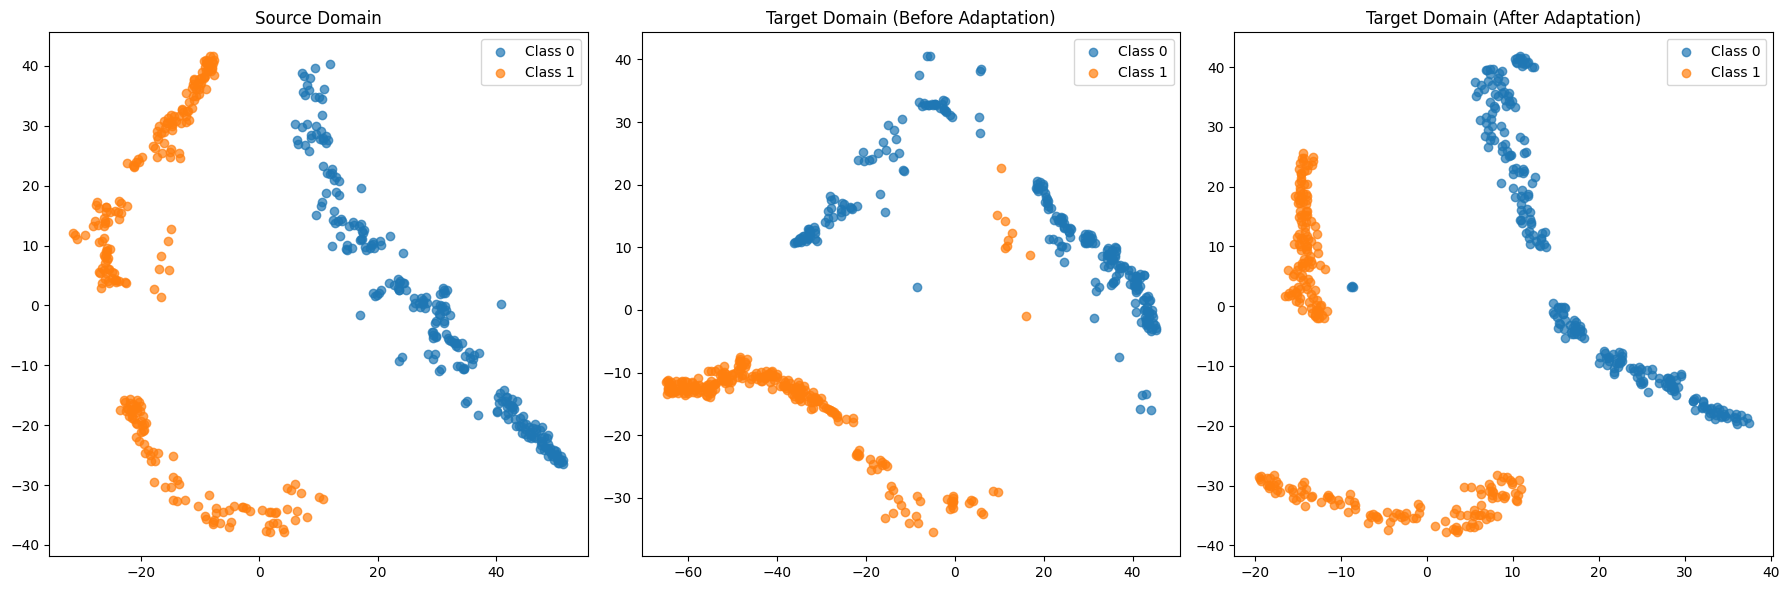

In [ ]:
plot_tsne_comparison(X_source_scaled, y_source, X_target_scaled, X_target_adapted, y_target)

### Modified optimal transport on a real-world dataset: MNIST to USPS digits




Computing initial OT plan...


/usr/local/lib/python3.11/dist-packages/ot/bregman/_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(


Starting information-loss optimization...
Iteration 0: Transport=0.1467, Info Loss=0.0039, Total=0.1507
Iteration 5: Transport=0.1467, Info Loss=0.0039, Total=0.1507
Iteration 10: Transport=0.1472, Info Loss=0.0007, Total=0.1479
Iteration 15: Transport=0.1472, Info Loss=0.0007, Total=0.1479
Iteration 20: Transport=0.1472, Info Loss=0.0007, Total=0.1479
Iteration 25: Transport=0.1472, Info Loss=0.0007, Total=0.1479
Iteration 30: Transport=0.1472, Info Loss=0.0007, Total=0.1479
Iteration 35: Transport=0.1472, Info Loss=0.0007, Total=0.1479
Iteration 40: Transport=0.1472, Info Loss=0.0007, Total=0.1479
Iteration 45: Transport=0.1472, Info Loss=0.0007, Total=0.1479
Final costs - Transport: 0.1472, Info Loss: 0.0007, Total: 0.1479
Label prediction accuracy: 0.8900
MNIST-USPS adaptation accuracy before: 0.7600
MNIST-USPS adaptation accuracy after: 0.8270


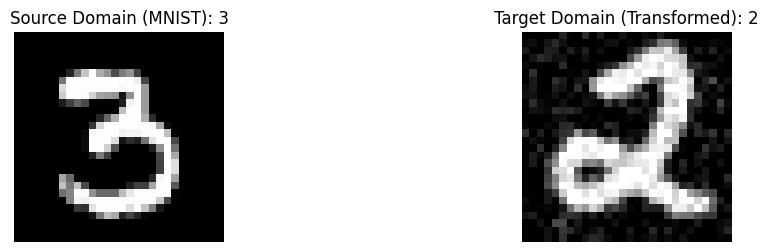

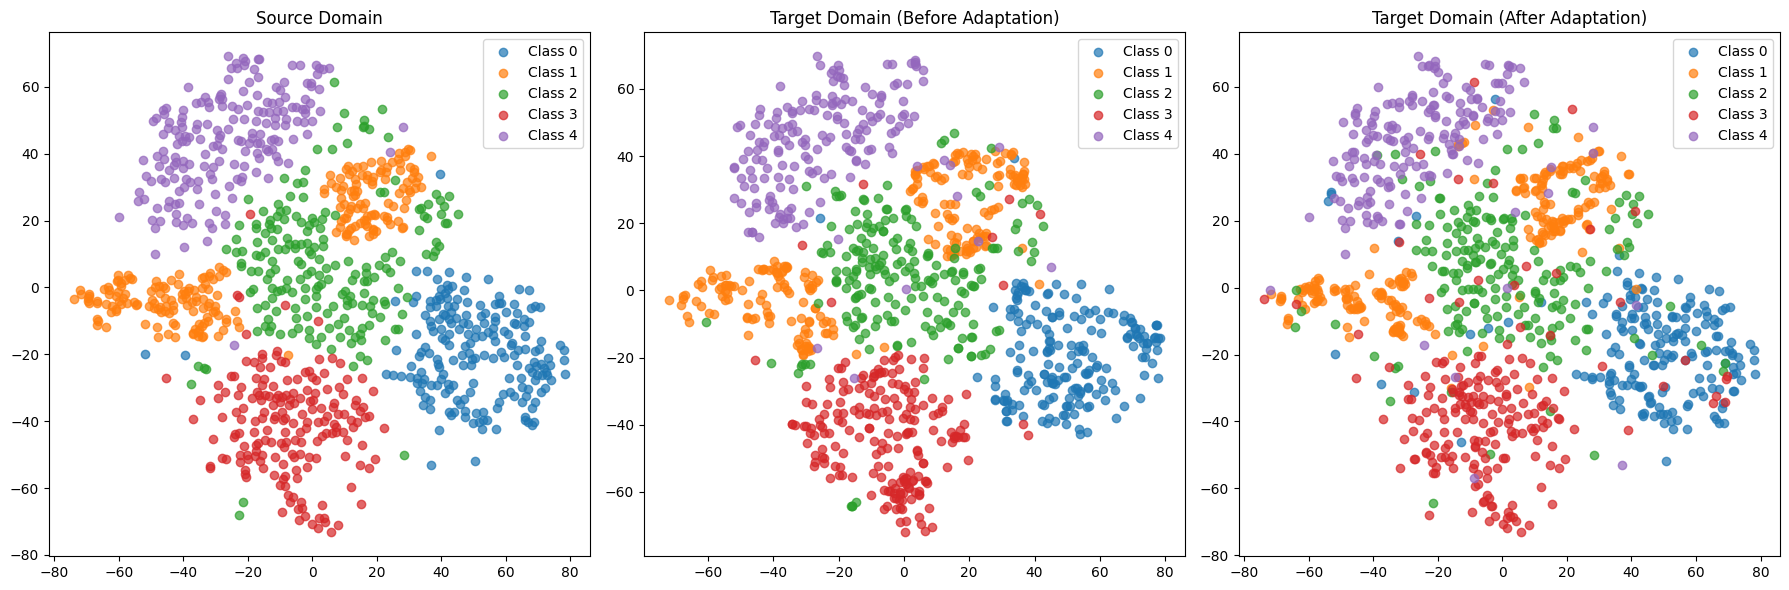

In [ ]:
def mnist_usps_adaptation():
    # First, let's create a simplified version of MNIST vs USPS adaptation
    # For this example, we'll use MNIST dataset but create a synthetic domain shift

    mnist = fetch_openml('mnist_784', version=1, as_frame=False, parser='auto')
    X, y = mnist.data, mnist.target.astype(int)


    idx = np.where((y >= 0) & (y < 5))[0]
    X, y = X[idx], y[idx]
    idx = np.random.choice(len(X), 2000, replace=False)
    X, y = X[idx], y[idx]

    X = X / 255.0
    X_source, X_target, y_source, y_target = train_test_split(X, y, test_size=0.5, random_state=42)

    def transform_images(X, image_size=28):
        X_transformed = np.zeros_like(X)
        for i in range(len(X)):
            img = X[i].reshape(image_size, image_size)

            # Apply a slight rotation and scaling (to simulate different writing styles)
            angle = np.random.uniform(-10, 10)
            img = rotate(img, angle, reshape=False)

            scale = np.random.uniform(0.8, 1.2)
            img = zoom(img, scale, order=1)

            # Crop or pad to maintain original size
            h, w = img.shape
            if h > image_size or w > image_size:
                # Crop the center
                start_h = max(0, (h - image_size) // 2)
                start_w = max(0, (w - image_size) // 2)
                img = img[start_h:start_h+image_size, start_w:start_w+image_size]
            else:
                # Pad with zeros
                new_img = np.zeros((image_size, image_size))
                start_h = max(0, (image_size - h) // 2)
                start_w = max(0, (image_size - w) // 2)
                new_img[start_h:start_h+h, start_w:start_w+w] = img
                img = new_img

            # Add noise
            img = img + np.random.normal(0, 0.1, img.shape)
            img = np.clip(img, 0, 1)

            X_transformed[i] = img.flatten()

        return X_transformed

    X_target = transform_images(X_target)

    # Reduce dimensionality for faster computation
    pca = PCA(n_components=50)
    X_source_pca = pca.fit_transform(X_source)
    X_target_pca = pca.transform(X_target)

    # Standardize
    scaler = StandardScaler()
    X_source_scaled = scaler.fit_transform(X_source_pca)
    X_target_scaled = scaler.transform(X_target_pca)

    # Evaluate before adaptation
    accuracy_before, _ = evaluate_without_adaptation(X_source_scaled, y_source, X_target_scaled, y_target)

    # Perform adaptation
    X_target_adapted, _ = ot_domain_adaptation_modified(X_source_scaled, y_source, X_target_scaled, y_target,
                                                    reg_e=0.01, alpha=1.0)

    # Evaluate after adaptation
    accuracy_after, _ = evaluate_without_adaptation(X_source_scaled, y_source, X_target_adapted, y_target)

    print(f"MNIST-USPS adaptation accuracy before: {accuracy_before:.4f}")
    print(f"MNIST-USPS adaptation accuracy after: {accuracy_after:.4f}")

    # Visualize some samples
    plt.figure(figsize=(12, 6))

    plt.subplot(2, 2, 1)
    idx = np.random.choice(len(X_source), 1)[0]
    plt.imshow(X_source[idx].reshape(28, 28), cmap='gray')
    plt.title(f'Source Domain (MNIST): {y_source[idx]}')
    plt.axis('off')

    plt.subplot(2, 2, 2)
    idx = np.random.choice(len(X_target), 1)[0]
    plt.imshow(X_target[idx].reshape(28, 28), cmap='gray')
    plt.title(f'Target Domain (Transformed): {y_target[idx]}')
    plt.axis('off')

    # Show t-SNE visualization
    plot_tsne_comparison(X_source_scaled, y_source, X_target_scaled, X_target_adapted, y_target)

# Run MNIST-USPS adaptation experiment
mnist_usps_adaptation()

### Modified Optimal Transport for Semi-Supervised Domain Adaptation

In [ ]:
def ot_semisupervised_domain_adaptation_modified(X_s, y_s, X_t, y_t_partial, reg_e=1e-1, reg_cl=0.1, alpha=1.0, numItermax=50):
    """
    Semi-supervised domain adaptation using optimal transport with information loss preservation

    Parameters:
    ----------
    X_s : array-like, shape (n_source_samples, n_features)
        Source domain data
    y_s : array-like, shape (n_source_samples,)
        Source domain labels
    X_t : array-like, shape (n_target_samples, n_features)
        Target domain data
    y_t_partial : array-like, shape (n_target_samples,)
        Partially labeled target domain (use -1 or np.nan for unknown)
    reg_e : float, optional (default=1e-1)
        Entropy regularization parameter
    reg_cl : float, optional (default=0.1)
        Class regularization strength
    alpha : float, optional (default=1.0)
        Weight for the information loss term
    numItermax : int, optional (default=50)
        Number of iterations

    Returns:
    -------
    X_t_adapted : array-like, shape (n_target_samples, n_features)
        Adapted source representation aligned to the target domain
    gamma : array-like, shape (n_source_samples, n_target_samples)
        Optimal transport plan
    """
    import numpy as np
    import ot
    from scipy.special import softmax

    n_source, n_target = X_s.shape[0], X_t.shape[0]
    n_classes = len(np.unique(y_s))

    # Cost matrix
    M = ot.dist(X_s, X_t, metric='sqeuclidean')
    M /= M.max()

    # Distributions
    a = np.ones((n_source,)) / n_source
    b = np.ones((n_target,)) / n_target

    # One-hot source label distributions
    label_distributions = np.zeros((n_source, n_classes))
    for i in range(n_source):
        label_distributions[i, y_s[i]] = 1.0

    # KL divergence matrix H
    H = np.zeros((n_source, n_source))
    for i in range(n_source):
        for j in range(n_source):
            if i == j:
                continue
            p_i = label_distributions[i] + 1e-10
            p_j = label_distributions[j] + 1e-10
            p_i /= p_i.sum()
            p_j /= p_j.sum()
            H[i, j] = np.sum(p_i * np.log(p_i / p_j))

    # Initial OT plan
    print("Computing initial OT plan...")
    gamma = ot.sinkhorn(a, b, M, reg=reg_e, numItermax=1000)

    # Iterative refinement
    print("Starting semi-supervised info-loss optimization...")

    for i in range(numItermax):
        # Compute similarity from gamma
        M_gamma = gamma @ gamma.T
        info_loss = np.sum(M_gamma * H)
        transport_cost = np.sum(gamma * M)
        total_cost = transport_cost + alpha * info_loss

        if i % 5 == 0:
            print(f"Iteration {i}: Transport={transport_cost:.4f}, Info Loss={info_loss:.4f}, Total={total_cost:.4f}")

        if i > 0 and i % 5 == 0:
            # Use partially labeled target to regularize cost matrix
            M_mod = M.copy()

            for c in range(n_classes):
                s_idx = np.where(y_s == c)[0]
                t_idx = np.where(y_t_partial == c)[0]

                if len(t_idx) > 0:
                    M_mod[np.ix_(s_idx, t_idx)] *= (1.0 - reg_cl)  # Encourage same-label match

                    for other_c in range(n_classes):
                        if other_c != c:
                            s_other = np.where(y_s == other_c)[0]
                            M_mod[np.ix_(s_other, t_idx)] *= (1.0 + reg_cl)  # Penalize mismatch

            # Recompute OT plan
            gamma = ot.sinkhorn(a, b, M_mod, reg=reg_e, numItermax=500)

    # Final adapted features
    col_sums = gamma.sum(axis=0, keepdims=True)
    col_sums[col_sums < 1e-8] = 1e-8
    X_t_adapted = (gamma / col_sums).T @ X_s
    X_t_adapted = np.nan_to_num(X_t_adapted)

    print(f"Final costs - Transport: {transport_cost:.4f}, Info Loss: {info_loss:.4f}, Total: {total_cost:.4f}")

    return X_t_adapted, gamma

### Testing semi-supervised version of Optimal Transport with Information Loss Criterion


Testing Semi-Supervised Domain Adaptation with Information Loss
Computing initial OT plan...
Starting information-loss optimization...
Iteration 0: Transport=0.0749, Info Loss=0.0153, Total=0.0902
Iteration 5: Transport=0.0749, Info Loss=0.0153, Total=0.0902
Iteration 10: Transport=0.0752, Info Loss=0.0126, Total=0.0878
Iteration 15: Transport=0.0752, Info Loss=0.0126, Total=0.0878
Iteration 20: Transport=0.0752, Info Loss=0.0126, Total=0.0878
Iteration 25: Transport=0.0752, Info Loss=0.0126, Total=0.0878
Iteration 30: Transport=0.0752, Info Loss=0.0126, Total=0.0878
Iteration 35: Transport=0.0752, Info Loss=0.0126, Total=0.0878
Iteration 40: Transport=0.0752, Info Loss=0.0126, Total=0.0878
Iteration 45: Transport=0.0752, Info Loss=0.0126, Total=0.0878
Final costs - Transport: 0.0752, Info Loss: 0.0126, Total: 0.0878
Label prediction accuracy: 0.7800
Computing initial OT plan...
Starting semi-supervised info-loss optimization...
Iteration 0: Transport=0.0749, Info Loss=0.0153, Total=0

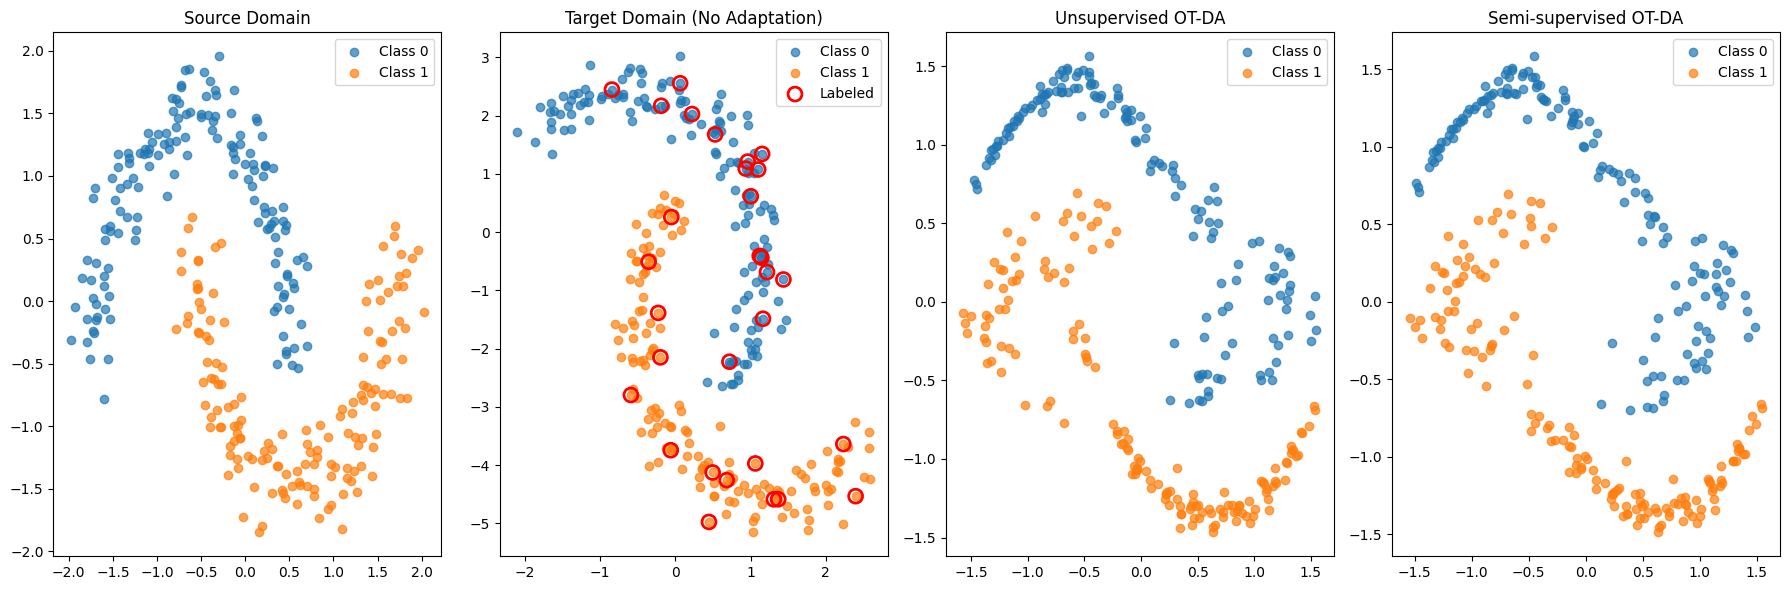

In [ ]:
def test_semisupervised():
    print("\nTesting Semi-Supervised Domain Adaptation with Information Loss")

    # Create domain adaptation problem
    X_s, y_s, X_t, y_t = create_domain_adaptation_problem(n_samples=300)

    # Standardize
    scaler = StandardScaler()
    X_s = scaler.fit_transform(X_s)
    X_t = scaler.transform(X_t)

    # Create partial labels scenario (only 10% of target samples are labeled)
    n_labeled = int(0.1 * len(y_t))
    labeled_idx = np.random.choice(len(y_t), n_labeled, replace=False)
    y_t_partial = np.full_like(y_t, -1)  # -1 for unlabeled
    y_t_partial[labeled_idx] = y_t[labeled_idx]

    # Unsupervised OT-DA
    X_t_unsup, _ = ot_domain_adaptation_modified(X_s, y_s, X_t, y_t, reg_e=0.01, alpha=1.0)
    unsup_acc, _ = evaluate_without_adaptation(X_s, y_s, X_t_unsup, y_t)

    # Semi-supervised OT-DA
    X_t_semisup, _ = ot_semisupervised_domain_adaptation_modified(X_s, y_s, X_t, y_t_partial, reg_e=0.01, alpha=1.0)
    semisup_acc, _ = evaluate_without_adaptation(X_s, y_s, X_t_semisup, y_t)

    # No adaptation
    no_adapt_acc, _ = evaluate_without_adaptation(X_s, y_s, X_t, y_t)

    print(f"No adaptation accuracy: {no_adapt_acc:.4f}")
    print(f"Unsupervised OT-DA accuracy: {unsup_acc:.4f}")
    print(f"Semi-supervised OT-DA accuracy (10% labeled): {semisup_acc:.4f}")

    # Visualize
    plt.figure(figsize=(18, 6))

    # Source
    plt.subplot(1, 4, 1)
    for c in np.unique(y_s):
        idx = y_s == c
        plt.scatter(X_s[idx, 0], X_s[idx, 1], label=f'Class {c}', alpha=0.7)
    plt.title('Source Domain')
    plt.legend()

    # Target (no adaptation)
    plt.subplot(1, 4, 2)
    for c in np.unique(y_t):
        idx = y_t == c
        plt.scatter(X_t[idx, 0], X_t[idx, 1], label=f'Class {c}', alpha=0.7)
    plt.scatter(X_t[labeled_idx, 0], X_t[labeled_idx, 1], s=100, facecolors='none',
                edgecolors='red', linewidth=2, label='Labeled')
    plt.title('Target Domain (No Adaptation)')
    plt.legend()

    # Target after unsupervised adaptation
    plt.subplot(1, 4, 3)
    for c in np.unique(y_t):
        idx = y_t == c
        plt.scatter(X_t_unsup[idx, 0], X_t_unsup[idx, 1], label=f'Class {c}', alpha=0.7)
    plt.title('Unsupervised OT-DA')
    plt.legend()

    # Target after semi-supervised adaptation
    plt.subplot(1, 4, 4)
    for c in np.unique(y_t):
        idx = y_t == c
        plt.scatter(X_t_semisup[idx, 0], X_t_semisup[idx, 1], label=f'Class {c}', alpha=0.7)
    plt.title('Semi-supervised OT-DA')
    plt.legend()

    plt.tight_layout()
    plt.show()

test_semisupervised()

## OT with Cluster Consistency

### Importing Libraries

In [ ]:
from scipy.special import rel_entr
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

### Optimal Transport with Intra Cluster Loss

In [ ]:
def ot_domain_adaptation_cluster_info_loss(X_s, y_s, X_t, y_t=None, reg_e=1e-1, alpha=1.0, n_clusters=5, numItermax=50):
    """
    OT domain adaptation with intra-cluster cross-entropy (information loss) penalty.

    Parameters:
    ----------
    X_s : np.ndarray
        Source features (n_source, d)
    y_s : np.ndarray
        Source labels (n_source,)
    X_t : np.ndarray
        Target features (n_target, d)
    y_t : np.ndarray, optional
        Target labels (for evaluation)
    reg_e : float
        Sinkhorn entropy regularization
    alpha : float
        Weight of information loss term
    n_clusters : int
        Number of clusters for source data
    numItermax : int
        Number of iterations for optimization

    Returns:
    -------
    X_t_adapted : np.ndarray
        Adapted source embeddings for target space
    gamma : np.ndarray
        Final transport plan
    """
    import numpy as np
    import ot
    from sklearn.cluster import KMeans
    from scipy.special import rel_entr

    n_source, n_target = X_s.shape[0], X_t.shape[0]
    M = ot.dist(X_s, X_t, metric='sqeuclidean')
    M /= M.max()

    a = np.ones((n_source,)) / n_source
    b = np.ones((n_target,)) / n_target

    n_classes = len(np.unique(y_s))
    label_distributions = np.zeros((n_source, n_classes))
    for i in range(n_source):
        label_distributions[i, y_s[i]] = 1.0

    # Cluster the source domain
    clusters = KMeans(n_clusters=n_clusters, random_state=0).fit(X_s).labels_

    # Compute intra-cluster cross-entropy matrix
    H = np.zeros((n_source, n_source))
    for i in range(n_source):
        for j in range(n_source):
            if clusters[i] == clusters[j]:
                p = label_distributions[i] + 1e-10
                q = label_distributions[j] + 1e-10
                p /= p.sum()
                q /= q.sum()
                H[i, j] = np.sum(p * np.log(p / q))
            else:
                H[i, j] = 0.0  # Inter-cluster ignored

    # Initial OT plan
    gamma = ot.sinkhorn(a, b, M, reg=reg_e, numItermax=1000)

    for i in range(numItermax):
        M_matrix = gamma @ gamma.T
        info_loss = np.sum(M_matrix * H)
        transport_cost = np.sum(gamma * M)
        total_cost = transport_cost + alpha * info_loss

        if i % 5 == 0:
            print(f"Iter {i}: Transport={transport_cost:.4f}, InfoLoss={info_loss:.4f}, Total={total_cost:.4f}")

        # Optional: modify cost matrix to reinforce cluster alignment
        if i > 0 and i % 10 == 0:
            pred_labels = np.array([y_s[np.argmax(gamma[:, j])] for j in range(n_target)])
            M_mod = M.copy()
            for c in range(n_classes):
                src_idx = np.where(y_s == c)[0]
                tgt_idx = np.where(pred_labels == c)[0]
                for s in src_idx:
                    M_mod[s, tgt_idx] *= 0.9
                for s in np.where(y_s != c)[0]:
                    M_mod[s, tgt_idx] *= 1.1
            gamma = ot.sinkhorn(a, b, M_mod, reg=reg_e, numItermax=500)

    final_info_loss = np.sum((gamma @ gamma.T) * H)
    final_transport_cost = np.sum(gamma * M)
    print(f"Final - Transport: {final_transport_cost:.4f}, InfoLoss: {final_info_loss:.4f}, Total: {final_transport_cost + alpha * final_info_loss:.4f}")

    col_sums = gamma.sum(axis=0, keepdims=True)
    col_sums[col_sums < 1e-8] = 1e-8
    X_t_adapted = (gamma / col_sums).T @ X_s
    X_t_adapted = np.nan_to_num(X_t_adapted)

    if y_t is not None:
        pred_labels = np.array([y_s[np.argmax(gamma[:, j])] for j in range(n_target)])
        acc = np.mean(pred_labels == y_t)
        print(f"Target label prediction accuracy: {acc:.4f}")

    return X_t_adapted, gamma

In [ ]:
# Perform domain adaptation
X_target_adapted, transport_matrix = ot_domain_adaptation_cluster_info_loss(
    X_source_scaled, y_source, X_target_scaled, y_target,
    reg_e=0.1, alpha=0.5, n_clusters=5, numItermax=30
)

# Evaluate classifier before and after adaptation
accuracy_before, clf_before = evaluate_without_adaptation(
    X_source_scaled, y_source, X_target_scaled, y_target
)

accuracy_after, clf_after = evaluate_without_adaptation(
    X_source_scaled, y_source, X_target_adapted, y_target
)

print(f"Accuracy before adaptation: {accuracy_before:.4f}")
print(f"Accuracy after adaptation: {accuracy_after:.4f}")

Iter 0: Transport=0.1166, InfoLoss=0.0014, Total=0.1172
Iter 5: Transport=0.1166, InfoLoss=0.0014, Total=0.1172
Iter 10: Transport=0.1166, InfoLoss=0.0014, Total=0.1172
Iter 15: Transport=0.1145, InfoLoss=0.0013, Total=0.1152
Iter 20: Transport=0.1145, InfoLoss=0.0013, Total=0.1152
Iter 25: Transport=0.1145, InfoLoss=0.0013, Total=0.1152
Final - Transport: 0.1145, InfoLoss: 0.0013, Total: 0.1152
Target label prediction accuracy: 0.5280
Accuracy before adaptation: 0.8280
Accuracy after adaptation: 0.9480


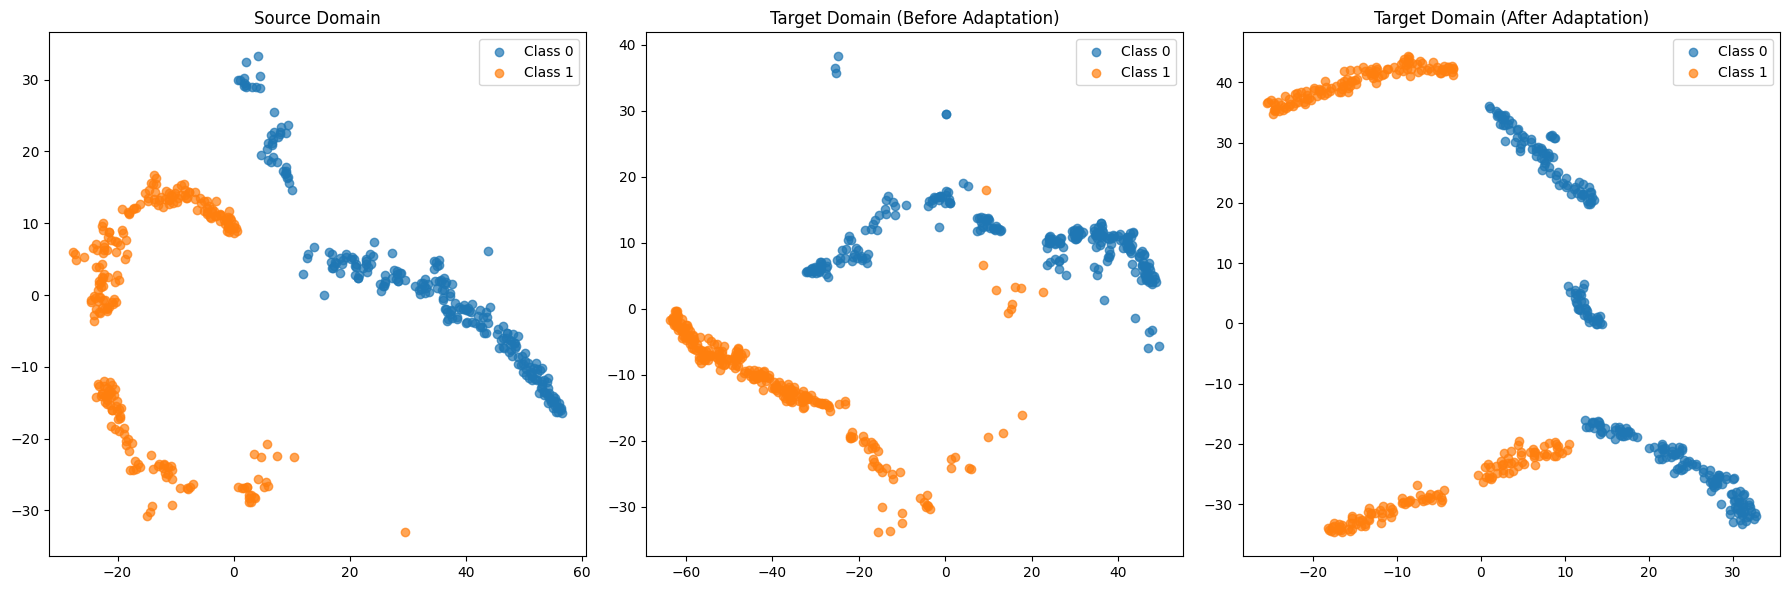

In [ ]:
plot_tsne_comparison(X_source_scaled, y_source, X_target_scaled, X_target_adapted, y_target)

### Modified optimal transport with cluster consistency on a real-world dataset: MNIST to USPS digits




Computing initial OT plan...


/usr/local/lib/python3.11/dist-packages/ot/bregman/_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(


Starting information-loss optimization...
Iteration 0: Transport=0.1501, Info Loss=0.0038, Total=0.1538
Iteration 5: Transport=0.1501, Info Loss=0.0038, Total=0.1538
Iteration 10: Transport=0.1505, Info Loss=0.0010, Total=0.1515
Iteration 15: Transport=0.1505, Info Loss=0.0010, Total=0.1515
Iteration 20: Transport=0.1505, Info Loss=0.0010, Total=0.1515
Iteration 25: Transport=0.1505, Info Loss=0.0010, Total=0.1515
Iteration 30: Transport=0.1505, Info Loss=0.0010, Total=0.1515
Iteration 35: Transport=0.1505, Info Loss=0.0010, Total=0.1515
Iteration 40: Transport=0.1505, Info Loss=0.0010, Total=0.1515
Iteration 45: Transport=0.1505, Info Loss=0.0010, Total=0.1515
Final costs - Transport: 0.1505, Info Loss: 0.0010, Total: 0.1515
Label prediction accuracy: 0.8840
MNIST-USPS adaptation accuracy before: 0.7410
MNIST-USPS adaptation accuracy after: 0.8080


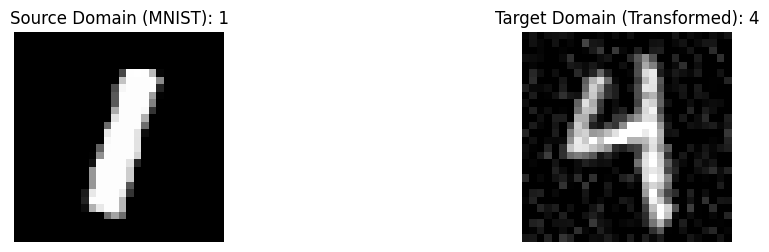

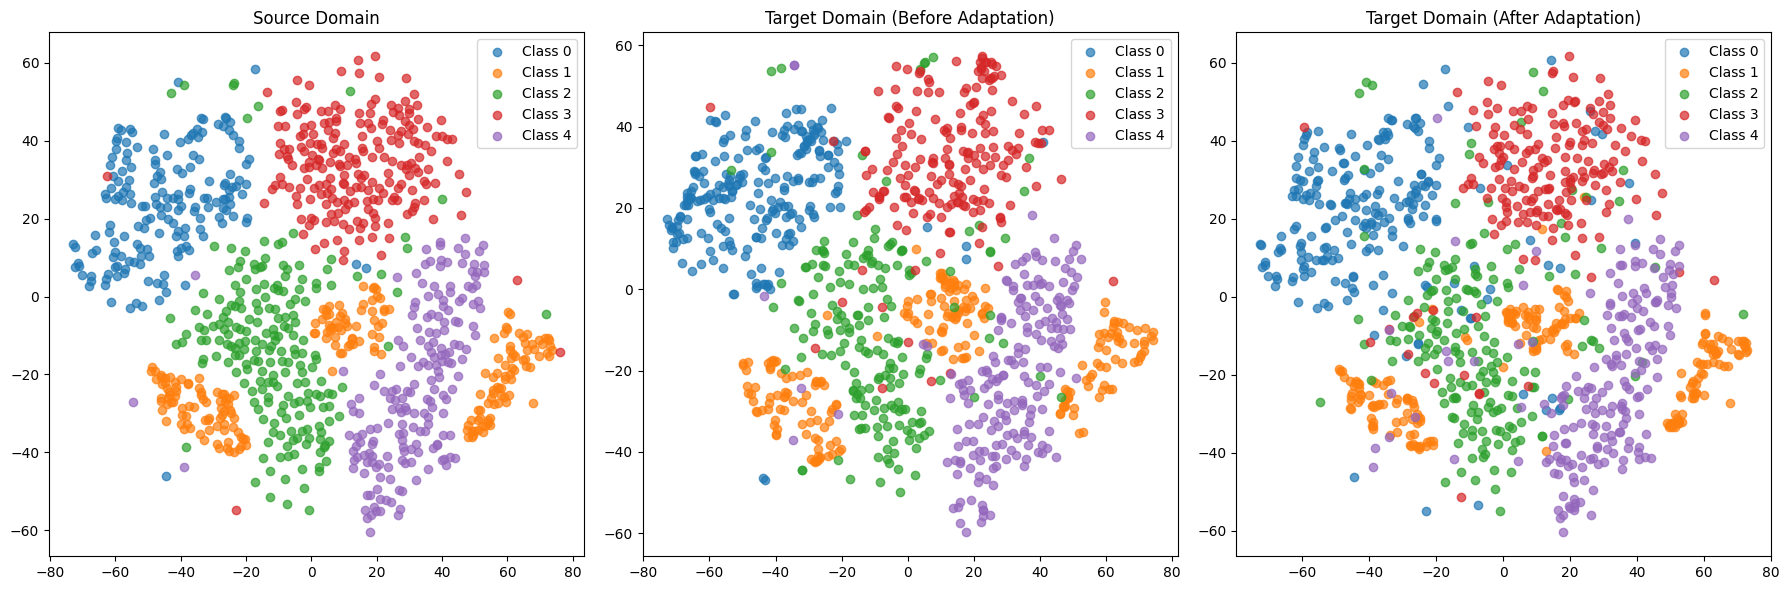

In [ ]:
def mnist_usps_adaptation():
    # First, let's create a simplified version of MNIST vs USPS adaptation
    # For this example, we'll use MNIST dataset but create a synthetic domain shift

    mnist = fetch_openml('mnist_784', version=1, as_frame=False, parser='auto')
    X, y = mnist.data, mnist.target.astype(int)


    idx = np.where((y >= 0) & (y < 5))[0]
    X, y = X[idx], y[idx]
    idx = np.random.choice(len(X), 2000, replace=False)
    X, y = X[idx], y[idx]

    X = X / 255.0
    X_source, X_target, y_source, y_target = train_test_split(X, y, test_size=0.5, random_state=42)

    def transform_images(X, image_size=28):
        X_transformed = np.zeros_like(X)
        for i in range(len(X)):
            img = X[i].reshape(image_size, image_size)

            # Apply a slight rotation and scaling (to simulate different writing styles)
            angle = np.random.uniform(-10, 10)
            img = rotate(img, angle, reshape=False)

            scale = np.random.uniform(0.8, 1.2)
            img = zoom(img, scale, order=1)

            # Crop or pad to maintain original size
            h, w = img.shape
            if h > image_size or w > image_size:
                # Crop the center
                start_h = max(0, (h - image_size) // 2)
                start_w = max(0, (w - image_size) // 2)
                img = img[start_h:start_h+image_size, start_w:start_w+image_size]
            else:
                # Pad with zeros
                new_img = np.zeros((image_size, image_size))
                start_h = max(0, (image_size - h) // 2)
                start_w = max(0, (image_size - w) // 2)
                new_img[start_h:start_h+h, start_w:start_w+w] = img
                img = new_img

            # Add noise
            img = img + np.random.normal(0, 0.1, img.shape)
            img = np.clip(img, 0, 1)

            X_transformed[i] = img.flatten()

        return X_transformed

    X_target = transform_images(X_target)

    # Reduce dimensionality for faster computation
    pca = PCA(n_components=50)
    X_source_pca = pca.fit_transform(X_source)
    X_target_pca = pca.transform(X_target)

    # Standardize
    scaler = StandardScaler()
    X_source_scaled = scaler.fit_transform(X_source_pca)
    X_target_scaled = scaler.transform(X_target_pca)

    # Evaluate before adaptation
    accuracy_before, _ = evaluate_without_adaptation(X_source_scaled, y_source, X_target_scaled, y_target)

    # Perform adaptation
    X_target_adapted, _ = ot_domain_adaptation_modified(X_source_scaled, y_source, X_target_scaled, y_target,
                                                    reg_e=0.01, alpha=1.0)

    # Evaluate after adaptation
    accuracy_after, _ = evaluate_without_adaptation(X_source_scaled, y_source, X_target_adapted, y_target)

    print(f"MNIST-USPS adaptation accuracy before: {accuracy_before:.4f}")
    print(f"MNIST-USPS adaptation accuracy after: {accuracy_after:.4f}")

    # Visualize some samples
    plt.figure(figsize=(12, 6))

    plt.subplot(2, 2, 1)
    idx = np.random.choice(len(X_source), 1)[0]
    plt.imshow(X_source[idx].reshape(28, 28), cmap='gray')
    plt.title(f'Source Domain (MNIST): {y_source[idx]}')
    plt.axis('off')

    plt.subplot(2, 2, 2)
    idx = np.random.choice(len(X_target), 1)[0]
    plt.imshow(X_target[idx].reshape(28, 28), cmap='gray')
    plt.title(f'Target Domain (Transformed): {y_target[idx]}')
    plt.axis('off')

    # Show t-SNE visualization
    plot_tsne_comparison(X_source_scaled, y_source, X_target_scaled, X_target_adapted, y_target)

# Run MNIST-USPS adaptation experiment
mnist_usps_adaptation()

### Modified Optimal Transport for Semi-Supervised Domain Adaptation

In [ ]:
def ot_semisupervised_domain_adaptation_modified(X_s, y_s, X_t, y_t_partial, reg_e=1e-1, reg_cl=0.1, alpha=1.0, numItermax=50):
    """
    Semi-supervised domain adaptation using optimal transport with information loss preservation

    Parameters:
    ----------
    X_s : array-like, shape (n_source_samples, n_features)
        Source domain data
    y_s : array-like, shape (n_source_samples,)
        Source domain labels
    X_t : array-like, shape (n_target_samples, n_features)
        Target domain data
    y_t_partial : array-like, shape (n_target_samples,)
        Partially labeled target domain (use -1 or np.nan for unknown)
    reg_e : float, optional (default=1e-1)
        Entropy regularization parameter
    reg_cl : float, optional (default=0.1)
        Class regularization strength
    alpha : float, optional (default=1.0)
        Weight for the information loss term
    numItermax : int, optional (default=50)
        Number of iterations

    Returns:
    -------
    X_t_adapted : array-like, shape (n_target_samples, n_features)
        Adapted source representation aligned to the target domain
    gamma : array-like, shape (n_source_samples, n_target_samples)
        Optimal transport plan
    """
    import numpy as np
    import ot
    from scipy.special import softmax

    n_source, n_target = X_s.shape[0], X_t.shape[0]
    n_classes = len(np.unique(y_s))

    # Cost matrix
    M = ot.dist(X_s, X_t, metric='sqeuclidean')
    M /= M.max()

    # Distributions
    a = np.ones((n_source,)) / n_source
    b = np.ones((n_target,)) / n_target

    # One-hot source label distributions
    label_distributions = np.zeros((n_source, n_classes))
    for i in range(n_source):
        label_distributions[i, y_s[i]] = 1.0

    # KL divergence matrix H
    H = np.zeros((n_source, n_source))
    for i in range(n_source):
        for j in range(n_source):
            if i == j:
                continue
            p_i = label_distributions[i] + 1e-10
            p_j = label_distributions[j] + 1e-10
            p_i /= p_i.sum()
            p_j /= p_j.sum()
            H[i, j] = np.sum(p_i * np.log(p_i / p_j))

    # Initial OT plan
    print("Computing initial OT plan...")
    gamma = ot.sinkhorn(a, b, M, reg=reg_e, numItermax=1000)

    # Iterative refinement
    print("Starting semi-supervised info-loss optimization...")

    for i in range(numItermax):
        # Compute similarity from gamma
        M_gamma = gamma @ gamma.T
        info_loss = np.sum(M_gamma * H)
        transport_cost = np.sum(gamma * M)
        total_cost = transport_cost + alpha * info_loss

        if i % 5 == 0:
            print(f"Iteration {i}: Transport={transport_cost:.4f}, Info Loss={info_loss:.4f}, Total={total_cost:.4f}")

        if i > 0 and i % 5 == 0:
            # Use partially labeled target to regularize cost matrix
            M_mod = M.copy()

            for c in range(n_classes):
                s_idx = np.where(y_s == c)[0]
                t_idx = np.where(y_t_partial == c)[0]

                if len(t_idx) > 0:
                    M_mod[np.ix_(s_idx, t_idx)] *= (1.0 - reg_cl)  # Encourage same-label match

                    for other_c in range(n_classes):
                        if other_c != c:
                            s_other = np.where(y_s == other_c)[0]
                            M_mod[np.ix_(s_other, t_idx)] *= (1.0 + reg_cl)  # Penalize mismatch

            # Recompute OT plan
            gamma = ot.sinkhorn(a, b, M_mod, reg=reg_e, numItermax=500)

    # Final adapted features
    col_sums = gamma.sum(axis=0, keepdims=True)
    col_sums[col_sums < 1e-8] = 1e-8
    X_t_adapted = (gamma / col_sums).T @ X_s
    X_t_adapted = np.nan_to_num(X_t_adapted)

    print(f"Final costs - Transport: {transport_cost:.4f}, Info Loss: {info_loss:.4f}, Total: {total_cost:.4f}")

    return X_t_adapted, gamma

### Testing semi-supervised version of Optimal Transport with Information Loss Criterion


Testing Semi-Supervised Domain Adaptation with Information Loss
Computing initial OT plan...
Starting information-loss optimization...
Iteration 0: Transport=0.0749, Info Loss=0.0153, Total=0.0902
Iteration 5: Transport=0.0749, Info Loss=0.0153, Total=0.0902
Iteration 10: Transport=0.0752, Info Loss=0.0126, Total=0.0878
Iteration 15: Transport=0.0752, Info Loss=0.0126, Total=0.0878
Iteration 20: Transport=0.0752, Info Loss=0.0126, Total=0.0878
Iteration 25: Transport=0.0752, Info Loss=0.0126, Total=0.0878
Iteration 30: Transport=0.0752, Info Loss=0.0126, Total=0.0878
Iteration 35: Transport=0.0752, Info Loss=0.0126, Total=0.0878
Iteration 40: Transport=0.0752, Info Loss=0.0126, Total=0.0878
Iteration 45: Transport=0.0752, Info Loss=0.0126, Total=0.0878
Final costs - Transport: 0.0752, Info Loss: 0.0126, Total: 0.0878
Label prediction accuracy: 0.7800
Computing initial OT plan...
Starting semi-supervised info-loss optimization...
Iteration 0: Transport=0.0749, Info Loss=0.0153, Total=0

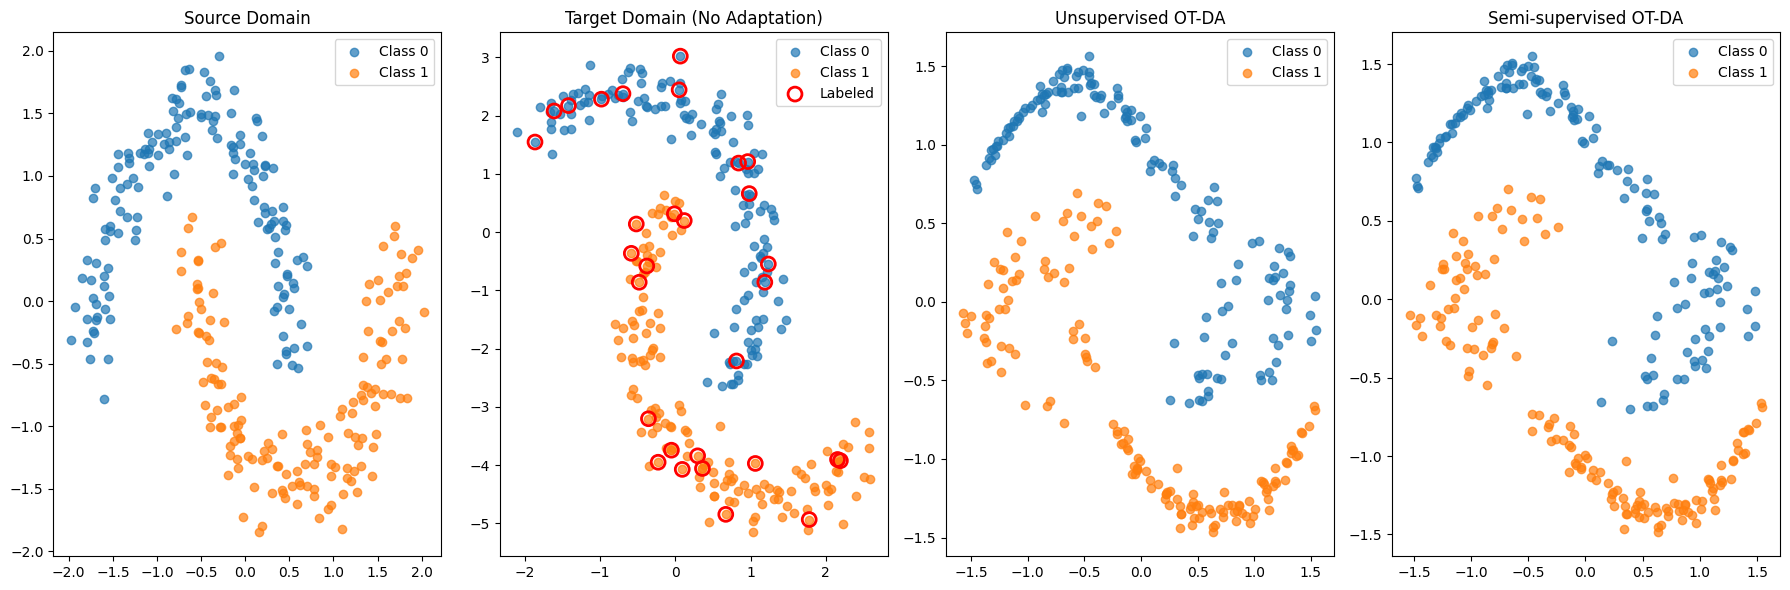

In [ ]:
def test_semisupervised():
    print("\nTesting Semi-Supervised Domain Adaptation with Information Loss")

    # Create domain adaptation problem
    X_s, y_s, X_t, y_t = create_domain_adaptation_problem(n_samples=300)

    # Standardize
    scaler = StandardScaler()
    X_s = scaler.fit_transform(X_s)
    X_t = scaler.transform(X_t)

    # Create partial labels scenario (only 10% of target samples are labeled)
    n_labeled = int(0.1 * len(y_t))
    labeled_idx = np.random.choice(len(y_t), n_labeled, replace=False)
    y_t_partial = np.full_like(y_t, -1)  # -1 for unlabeled
    y_t_partial[labeled_idx] = y_t[labeled_idx]

    # Unsupervised OT-DA
    X_t_unsup, _ = ot_domain_adaptation_modified(X_s, y_s, X_t, y_t, reg_e=0.01, alpha=1.0)
    unsup_acc, _ = evaluate_without_adaptation(X_s, y_s, X_t_unsup, y_t)

    # Semi-supervised OT-DA
    X_t_semisup, _ = ot_semisupervised_domain_adaptation_modified(X_s, y_s, X_t, y_t_partial, reg_e=0.01, alpha=1.0)
    semisup_acc, _ = evaluate_without_adaptation(X_s, y_s, X_t_semisup, y_t)

    # No adaptation
    no_adapt_acc, _ = evaluate_without_adaptation(X_s, y_s, X_t, y_t)

    print(f"No adaptation accuracy: {no_adapt_acc:.4f}")
    print(f"Unsupervised OT-DA accuracy: {unsup_acc:.4f}")
    print(f"Semi-supervised OT-DA accuracy (10% labeled): {semisup_acc:.4f}")

    # Visualize
    plt.figure(figsize=(18, 6))

    # Source
    plt.subplot(1, 4, 1)
    for c in np.unique(y_s):
        idx = y_s == c
        plt.scatter(X_s[idx, 0], X_s[idx, 1], label=f'Class {c}', alpha=0.7)
    plt.title('Source Domain')
    plt.legend()

    # Target (no adaptation)
    plt.subplot(1, 4, 2)
    for c in np.unique(y_t):
        idx = y_t == c
        plt.scatter(X_t[idx, 0], X_t[idx, 1], label=f'Class {c}', alpha=0.7)
    plt.scatter(X_t[labeled_idx, 0], X_t[labeled_idx, 1], s=100, facecolors='none',
                edgecolors='red', linewidth=2, label='Labeled')
    plt.title('Target Domain (No Adaptation)')
    plt.legend()

    # Target after unsupervised adaptation
    plt.subplot(1, 4, 3)
    for c in np.unique(y_t):
        idx = y_t == c
        plt.scatter(X_t_unsup[idx, 0], X_t_unsup[idx, 1], label=f'Class {c}', alpha=0.7)
    plt.title('Unsupervised OT-DA')
    plt.legend()

    # Target after semi-supervised adaptation
    plt.subplot(1, 4, 4)
    for c in np.unique(y_t):
        idx = y_t == c
        plt.scatter(X_t_semisup[idx, 0], X_t_semisup[idx, 1], label=f'Class {c}', alpha=0.7)
    plt.title('Semi-supervised OT-DA')
    plt.legend()

    plt.tight_layout()
    plt.show()

test_semisupervised()